# Break Through Tech AI - Cornell University Team Interactions

Objective: Create binary classification model that detects robot spam calls from human voice utilizing supervised neural network algorithm.

Members: Lizelle Ocfemia, Siying Ding, Yeseon Kim, Daniella Qira


# Imports and Drive Mounting

In [ ]:
%pip install datasets
%pip install gTTS
%pip install librosa
%pip install torchaudio
# %pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 36.2 MB/s eta 0:00:00


In [ ]:
from datasets.builder import ReadInstruction
from datasets import load_dataset
from torch.utils.data import DataLoader
import io
import pandas as pd
import IPython.display as ipd
from pathlib import Path
import numpy as np
import librosa
from ast import literal_eval
import torchaudio
from datasets import Dataset
from datasets import load_from_disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # THIS COMMAND MOUNTS YOUR GOOGLE DRIVE TO COLAB

Mounted at /content/drive


In [ ]:
# DO NOT need to run this bc we doing everything locally

# from huggingface_hub import notebook_login
# from torch.utils.data.sampler import BatchSampler, RandomSampler
# notebook_login()

# # allows user to access huggingface datasets (must set up keys!)

# **Extracting dataset_resources**

## To run the next codeblock, you must first add a shortcut to our shared folder to your drive. ##

---
1. Open the "Interactions (NYC) - SpoofProof: Audio Classification" folder from your drive
2. Right-click the folder -> "Organize" -> "Add shortcut" -> "My Drive" -> Add
3. Proceed to the next steps :)

In [ ]:
!mkdir 'training_dataset'
!mkdir 'training_dataset/synthesized_audio'

# extract train.csv and all audiofiles
!tar -xvf  '/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/en_train_0.tar' -C '/content/training_dataset' # extract en_train_0 from GOOGLE DRIVE
!tar -xvf  '/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/syn_en_train_0.tar' -C '/content/training_dataset' # extract syn_en_train_0 from GOOGLE DRIVE

Streaming output truncated to the last 5000 lines.
synthesized_audio/syn_36167.mp3
synthesized_audio/syn_11989.mp3
synthesized_audio/syn_27056.mp3
synthesized_audio/syn_7172.mp3
synthesized_audio/syn_14628.mp3
synthesized_audio/syn_32374.mp3
synthesized_audio/syn_37103.mp3
synthesized_audio/syn_16309.mp3
synthesized_audio/syn_29026.mp3
synthesized_audio/syn_13817.mp3
synthesized_audio/syn_30678.mp3
synthesized_audio/syn_11862.mp3
synthesized_audio/syn_13119.mp3
synthesized_audio/syn_8147.mp3
synthesized_audio/syn_37776.mp3
synthesized_audio/syn_11747.mp3
synthesized_audio/syn_3227.mp3
synthesized_audio/syn_9666.mp3
synthesized_audio/syn_39113.mp3
synthesized_audio/syn_11759.mp3
synthesized_audio/syn_9722.mp3
synthesized_audio/syn_17378.mp3
synthesized_audio/syn_4238.mp3
synthesized_audio/syn_9995.mp3
synthesized_audio/syn_20836.mp3
synthesized_audio/syn_33471.mp3
synthesized_audio/syn_7266.mp3
synthesized_audio/syn_19483.mp3
synthesized_audio/syn_9208.mp3
synthesized_audio/syn_14328.mp

In [ ]:
# dataset = load_dataset('/content/training_dataset/en_train_0', split='train') # LOAD DATASET LOCALLY
# audio_ds = load_dataset("audiofolder", data_dir="/path/to/folder_without_metadata", drop_labels=True)

In [ ]:
# HOW TO LOAD NEW XS DATASET
dataset = load_from_disk('/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/train_xs')
dataset

Dataset({
    features: ['path', 'sentence', 'synthetic', 'array', '__index_level_0__'],
    num_rows: 1000
})

In [ ]:
# df2 = pd.read_csv('/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/train.tsv',sep='\t') # READ TRAIN.TSV FILE WITH ALL OF OTHER FEATURES
# df2 = df2.iloc[:40000] # Our training audio dataset only contains 40k. Slice

df2 = pd.read_csv('/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/audio_df.csv') # Read NEW audio_df.csv file (Siying's)
df2.tail(10)

,Unnamed: 0,path,sentence,synthetic
79990,79990,syn_39990.mp3,Its current warden is James Beale.,1
79991,79991,syn_39991.mp3,Attempts have been made to promote isospin fro...,1
79992,79992,syn_39992.mp3,"After initial criticism, Helton gained the num...",1
79993,79993,syn_39993.mp3,They completed research of a large part of Vom...,1
79994,79994,syn_39994.mp3,The building is known for its air of great tra...,1
79995,79995,syn_39995.mp3,LeBleu supported the livestock show and rodeo ...,1
79996,79996,syn_39996.mp3,Xe is also an important fission product.,1
79997,79997,syn_39997.mp3,Its composition is mainly granodiorite with ph...,1
79998,79998,syn_39998.mp3,We were making a difference.,1
79999,79999,syn_39999.mp3,I can deal with that.,1


In [ ]:
# checking if all audio files exist

ogPath = []
synPath = []

syn = 40000

for i in range(syn):
  audio = '/content/training_dataset/en_train_0/' + df2['path'][i] # ADD CORRECT PATH TO AUDIO PATH
  if Path(audio).is_file() == False:
    print(audio + ' DOES NOT EXIST!!') # PRINT AUDIO FILES THAT DONT EXIST IN DATASET
  else:
    ogPath.append(audio)

if len(ogPath) == syn:
  print('All en_train_0 files found! :D')

for i in range(syn):
  audio = f"{'/content/training_dataset/synthesized_audio/' + df2['path'][syn + i]}" # ADD CORRECT PATH TO AUDIO PATH
  if Path(audio).is_file() == False:
    print(audio + ' DOES NOT EXIST!!') # PRINT AUDIO FILES THAT DONT EXIST IN DATASET
  else:
    synPath.append(audio)

if len(synPath) == syn:
  print('All syn_train_0 files found! :D')

# check if audio files are aligned

ipd.display(ipd.Audio(ogPath[39500]))
ipd.display(ipd.Audio(synPath[39500]))
print(ogPath[39500])
print(synPath[39500])

All en_train_0 files found! :D
All syn_train_0 files found! :D


/content/training_dataset/en_train_0/common_voice_en_25484239.mp3
/content/training_dataset/synthesized_audio/syn_39500.mp3


# Dataset Clean Up
next steps:
- clean out null vals -> only use audio
- add fake audio feature to df
- add labels for original or synthetic!
- create numpy array from audio mp3
- convert array to wav2vec

In [ ]:
# df2['ogPath'] = ogPath # ADD NEW PATH TO DATAFRAME

# Where Siying's work starts
df2.head()

,",path,sentence,synthetic"
0,"0,common_voice_en_21635524.mp3,This device has..."
1,"1,common_voice_en_21635525.mp3,This product is..."
2,"2,common_voice_en_21635526.mp3,It is named aft..."
3,"3,common_voice_en_21635527.mp3,It is north wes..."
4,"4,common_voice_en_28821136.mp3,He was a nephew..."


In [ ]:
# Extract "path" and "sentence" labels
# path: allows us to retrieve each row's corresponding audio file
# sentence: transcript of the audio
df2 = df2[['path', 'sentence']]
df2.head()

,path,sentence
0,common_voice_en_21635524.mp3,This device has a cathode inside an anode wire...
1,common_voice_en_21635525.mp3,This product is almost always produced by the ...
2,common_voice_en_21635526.mp3,It is named after Edward Singleton Holden.
3,common_voice_en_21635527.mp3,It is north west of the regional centre of Clare.
4,common_voice_en_28821136.mp3,He was a nephew of Rear-Admiral Sir Francis Au...


In [ ]:
oGpath = '/content/training_dataset/en_train_0/'
synPath = '/content/training_dataset/synthesized_audio/'

In [ ]:
# Add a binary label called "synthetic" (1 if synthetic, 0 if not synthetic) to check whether the audio is synthetic or not
df2['synthetic'] = np.zeros((40000,), dtype=int) # All 1s since these audios come from Common Voice Dataset, which are real voices

In [ ]:
df2.head()

In [ ]:
df2.shape

In [ ]:
# Add 40k synthetic audios' path, sentence, and synthetic (1) labels into df2
for i in range(40000):
  df2.loc[len(df2.index)] = ['syn_'+str(i)+".mp3", df2.loc[i]['sentence'], 1]

In [ ]:
# Check shape and tail to see if 40k synthetic rows are successfully added
df2.shape

In [ ]:
# Check tail
df2.tail(10)

In [ ]:
df2.to_csv('/content/training_dataset/audio_df.csv', index=False) # made df a .csv so we dont have to keep loading this ^


# Decode Audio
Lizelle: try using ``librosa.load`` to generate numpy arrays


In [ ]:
from google.colab import files
files.download('/content/training_dataset/synthesized_audio/syn_39500.mp3')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
audio_xs = df2.iloc[np.r_[39500:40000, 79500:80000]] # make new smaller dataset of 5000-5000

In [ ]:
audio_xs['sentence'][79500]

'Its therapeutic use is not a modern phenomenon.'

In [ ]:
df_array = audio_xs

In [ ]:
df_array['array'] = list(np.array(np.zeros(1000),dtype=object))

In [ ]:
df_array = df_array.drop(columns=['Unnamed: 0'])

In [ ]:
len(literal_eval(df_array['array'][0]))

195840

In [ ]:
df_array['array'] = df_array['array'].apply(literal_eval)

In [ ]:
# stolen from https://colab.research.google.com/github/m3hrdadfi/soxan/blob/main/notebooks/Emotion_recognition_in_Greek_speech_using_Wav2Vec2.ipynb#scrollTo=6UqlIV3uGxDA


ogPath = '/content/training_dataset/en_train_0/'
synPath = '/content/training_dataset/synthesized_audio/'

target_sr = 16000 # for wav2vec

def speech_file_to_array_fn(path):
    speech_array, sr = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sr, target_sr)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


In [ ]:
speech_file_to_array_fn(ogPath + df_array.iloc[0]['path'])

array([-6.2035812e-14, -2.4428023e-12, -5.7327998e-13, ...,
        1.2210761e-06,  4.1921130e-06, -6.4963733e-06], dtype=float32)

----------

In [ ]:
for i in range(500): # just do 500 orig files
  df_array.loc[[39500 + i], 'array'] = pd.Series([list(speech_file_to_array_fn(ogPath + df_array.iloc[i]['path']))], index=df_array.index[[i]])

for i in range(500): # just do 500 syn files
  df_array.loc[[79500 + i], 'array'] = pd.Series([list(speech_file_to_array_fn(synPath + df_array.iloc[500 + i]['path']))], index=df_array.index[[500 + i]])

In [ ]:
df_array

,path,sentence,synthetic,array
39500,common_voice_en_25484239.mp3,Its therapeutic use is not a modern phenomenon.,0,"[-6.203581e-14, -2.4428023e-12, -5.7328e-13, -..."
39501,common_voice_en_25484240.mp3,Another is more related to the economic growth...,0,"[-1.281586e-13, 2.7612626e-12, -2.5194273e-13,..."
39502,common_voice_en_25484241.mp3,They don't think it be what it is but it do.,0,"[6.0364994e-13, -7.36755e-13, 2.3630915e-13, 9..."
39503,common_voice_en_25024679.mp3,"Smart, Henry L. Jackson and Arnold Gingrich.",0,"[-5.021227e-15, 6.1982205e-14, -1.6710517e-14,..."
39504,common_voice_en_25024681.mp3,Taylor fled to Canada.,0,"[1.8711604e-13, 2.2190362e-12, 2.0234292e-12, ..."
...,...,...,...,...
79995,syn_39995.mp3,LeBleu supported the livestock show and rodeo ...,1,"[-4.0089265e-15, -2.0063165e-14, -7.121812e-15..."
79996,syn_39996.mp3,Xe is also an important fission product.,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
79997,syn_39997.mp3,Its composition is mainly granodiorite with ph...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
79998,syn_39998.mp3,We were making a difference.,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
train_ds = load_dataset("csv", data_files ={"/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/audio_xs.csv"})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
df_array.to_csv('/content/training_dataset/audio_xs.csv') # save to csv file

In [ ]:
train_ds['train']['array']

In [ ]:
# reload = load_from_disk('train_xs')
dataset = load_from_disk('/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/train_xs')
dataset

Dataset({
    features: ['path', 'sentence', 'synthetic', 'array', '__index_level_0__'],
    num_rows: 1000
})

In [ ]:
dataset['array'][0]

In [ ]:
train_ds.save_to_disk('train_xs')

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
!mv /content/training_dataset/audio_xs.csv '/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/audio_xs.csv'

In [ ]:
!mv /content/train_xs '/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/train_xs'

Make dataset from pandas dataframe

In [ ]:
train_dataset

Dataset({
    features: ['path', 'sentence', 'synthetic', 'array', '__index_level_0__'],
    num_rows: 1000
})

## How to reproduce audio file creation



In [ ]:
from gtts import gTTS
import shutil # used to move audio files to new path
import time

# The text that you want to convert to audio
mytext = df2['sentence'][17109:18500] # I did 10k in parallel with four other emails bc this shit took too long

# Language in which you want to convert
language = 'en'

path = '/content/training_dataset/synthesized_audio/'
i = 17109 # make sure this matches to the start of your mytext index

for texts in mytext:
  myobj = gTTS(text=texts, lang=language, slow=False)
  filename = f"{'syn_' + str(i)}.mp3"  # Generating a unique filename
  myobj.save(filename)
  shutil.move(filename, path + filename) # theres prob a faster way to do this
  print(filename)
  i += 1
  time.sleep(1) # one second was the fastest delay before you get locked out of gtts for a couple of hours :skull:


#     # Playing the converted audio
# ipd.display(ipd.Audio(path + filename))

syn_17109.mp3
syn_17110.mp3
syn_17111.mp3
syn_17112.mp3
syn_17113.mp3
syn_17114.mp3
syn_17115.mp3
syn_17116.mp3
syn_17117.mp3
syn_17118.mp3
syn_17119.mp3
syn_17120.mp3
syn_17121.mp3
syn_17122.mp3
syn_17123.mp3
syn_17124.mp3
syn_17125.mp3
syn_17126.mp3
syn_17127.mp3
syn_17128.mp3
syn_17129.mp3
syn_17130.mp3
syn_17131.mp3
syn_17132.mp3
syn_17133.mp3
syn_17134.mp3
syn_17135.mp3
syn_17136.mp3
syn_17137.mp3
syn_17138.mp3
syn_17139.mp3
syn_17140.mp3
syn_17141.mp3
syn_17142.mp3
syn_17143.mp3
syn_17144.mp3
syn_17145.mp3
syn_17146.mp3
syn_17147.mp3
syn_17148.mp3
syn_17149.mp3
syn_17150.mp3
syn_17151.mp3
syn_17152.mp3
syn_17153.mp3
syn_17154.mp3
syn_17155.mp3
syn_17156.mp3
syn_17157.mp3
syn_17158.mp3
syn_17159.mp3
syn_17160.mp3
syn_17161.mp3
syn_17162.mp3
syn_17163.mp3
syn_17164.mp3
syn_17165.mp3
syn_17166.mp3
syn_17167.mp3
syn_17168.mp3
syn_17169.mp3
syn_17170.mp3
syn_17171.mp3
syn_17172.mp3
syn_17173.mp3
syn_17174.mp3
syn_17175.mp3
syn_17176.mp3
syn_17177.mp3
syn_17178.mp3
syn_17179.mp3
syn_17

gTTSError: ignored

In [ ]:
# tar synthesized audio [0:1859] for lossless compression
!tar -czvf  syn_en_train_0.tar '/synthesized_audio'

Streaming output truncated to the last 5000 lines.
/synthesized_audio/syn_36167.mp3
/synthesized_audio/syn_11989.mp3
/synthesized_audio/syn_27056.mp3
/synthesized_audio/syn_7172.mp3
/synthesized_audio/syn_14628.mp3
/synthesized_audio/syn_32374.mp3
/synthesized_audio/syn_37103.mp3
/synthesized_audio/syn_16309.mp3
/synthesized_audio/syn_29026.mp3
/synthesized_audio/syn_13817.mp3
/synthesized_audio/syn_30678.mp3
/synthesized_audio/syn_11862.mp3
/synthesized_audio/syn_13119.mp3
/synthesized_audio/syn_8147.mp3
/synthesized_audio/syn_37776.mp3
/synthesized_audio/syn_11747.mp3
/synthesized_audio/syn_3227.mp3
/synthesized_audio/syn_9666.mp3
/synthesized_audio/syn_39113.mp3
/synthesized_audio/syn_11759.mp3
/synthesized_audio/syn_9722.mp3
/synthesized_audio/syn_17378.mp3
/synthesized_audio/syn_4238.mp3
/synthesized_audio/syn_9995.mp3
/synthesized_audio/syn_20836.mp3
/synthesized_audio/syn_33471.mp3
/synthesized_audio/syn_7266.mp3
/synthesized_audio/syn_19483.mp3
/synthesized_audio/syn_9208.mp3
/

In [ ]:
# copy tarball to google drive
%cp synthesized_audio_13580_18483.tar '/content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources/synthesized_audio_13580_18483.tar'

trying out this https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/

## Mel  Frequency Cepstral Coefficients (MFCC)

In [ ]:
trg_sr = 16000
audio_arr = dataset['array']

def get_mfcc(idx):
  mfcc = np.array(librosa.feature.mfcc(y=np.array(audio_arr[idx]), sr=trg_sr))
  return mfcc

In [ ]:
len(audio_arr)

1000

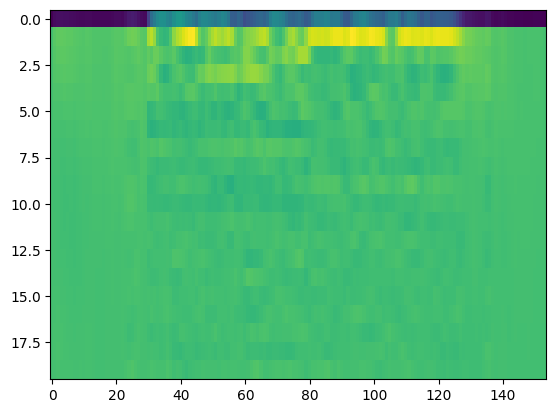

In [ ]:
from matplotlib import pyplot

mfcc = get_mfcc(0)
pyplot.imshow(mfcc, interpolation='nearest', aspect='auto')
pyplot.show()

## Mel Spectrogram


In [ ]:
def get_melspectrogram(idx):
  melspectrogram = np.array(librosa.feature.melspectrogram(y=np.array(audio_arr[idx]), sr=trg_sr))
  return melspectrogram

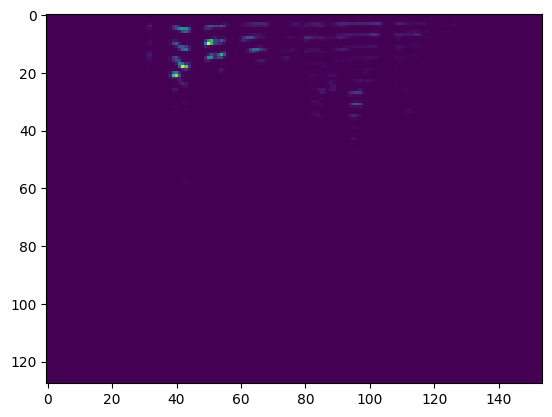

In [ ]:
melspectrogram = get_melspectrogram(0)
pyplot.imshow(melspectrogram, interpolation='nearest', aspect='auto')
pyplot.show()

## Chroma Vector


In [ ]:
def get_chroma_vector(idx):
  chroma = np.array(librosa.feature.chroma_stft(y=np.array(audio_arr[idx]), sr=trg_sr))
  return chroma

In [ ]:
chroma = get_chroma_vector(0)
pyplot.imshow(chroma, interpolation='nearest', aspect='auto')
pyplot.show()

## Tonal Centroid Features (Tonnetz)

In [ ]:
def get_tonnetz(idx):
  tonnetz = np.array(librosa.feature.tonnetz(y=np.array(audio_arr[idx]), sr=trg_sr))
  return tonnetz

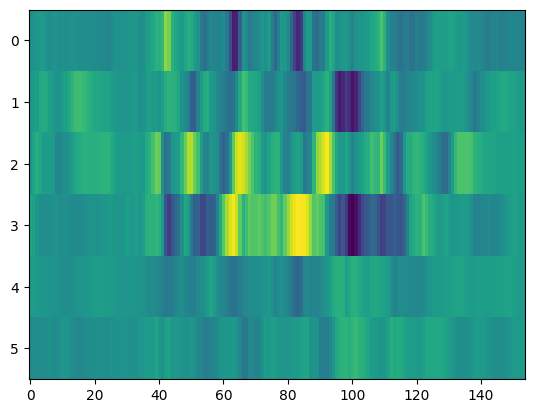

In [ ]:
tntz = get_tonnetz(0)
pyplot.imshow(tntz , interpolation='nearest', aspect='auto')
pyplot.show()

## Putting the Features together

In [ ]:
def get_feature(idx):
  # Extracting MFCC feature
  mfcc = get_mfcc(idx)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(idx)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = np.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(idx)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(idx)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = np.concatenate( (tntz_mean, tntz_min, tntz_max) )

  feature = np.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

In [ ]:
# get features
features = []

for i in range(1000):
  feature = get_feature(i)
  features.append(feature)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=462
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=474
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=438
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=366
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=312
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=444
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWa

In [ ]:
labels = dataset['synthetic']

In [ ]:
len(features)

1000

## Training

In [ ]:
# split dataset

permutations = np.random.permutation(1000)
features = np.array(features)[permutations]
labels = np.array(labels)[permutations]

features_train = features[0:800]
labels_train = labels[0:800]

features_val = features[800:900]
labels_val = labels[800:900]

features_test = features[900:1000]
labels_test = labels[900:1000]

In [ ]:

from tensorflow import keras

inputs = keras.Input(shape=(498), name="feature")
x = keras.layers.Dense(300, activation="relu", name="dense_1")(inputs)
x = keras.layers.Dense(200, activation="relu", name="dense_2")(x)
outputs = keras.layers.Dense(3, activation="softmax", name="predictions")(x)


model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    # Optimizer
    optimizer=keras.optimizers.RMSprop(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
model.fit(x=features_train.tolist(),y=labels_train.tolist(),verbose=1,validation_data=(features_val.tolist() , labels_val.tolist()), epochs=32)

Epoch 1/32
25/25 [==============================] - 2s 63ms/step - loss: 21.7466 - sparse_categorical_accuracy: 0.8763 - val_loss: 0.6968 - val_sparse_categorical_accuracy: 0.9500
Epoch 2/32
25/25 [==============================] - 0s 5ms/step - loss: 1.4609 - sparse_categorical_accuracy: 0.9488 - val_loss: 18.6196 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/32
25/25 [==============================] - 0s 5ms/step - loss: 3.7366 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.5681 - val_sparse_categorical_accuracy: 0.9700
Epoch 4/32
25/25 [==============================] - 0s 5ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.1992 - val_sparse_categorical_accuracy: 0.9800
Epoch 5/32
25/25 [==============================] - 0s 5ms/step - loss: 5.7175e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1966 - val_sparse_categorical_accuracy: 0.9800
Epoch 6/32
25/25 [==============================] - 0s 6ms/step - loss: 1.7051e-06 - sparse_categorical

In [ ]:
score = model.evaluate(x=features_test.tolist(),y=labels_test.tolist(), verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')

Accuracy : 99.00000095367432%


In [ ]:
from pydub import AudioSegment
t1 = 60000 #Works in milliseconds
t2 = 90000
waveFile = AudioSegment.from_file("audio_sample_full.wav")
waveFile = waveFile[t1:t2]
waveFile.export('audio_sample_30s.wav', format="wav")

In [ ]:
file_path = "audio_sample_30s.wav"
feature = get_feature(file_path)
y = model.predict(feature.reshape(1,498))
ind = numpy.argmax(y)
genres[ind]

# Load Audio in Feature Extraction

In [ ]:
trg_sr = 16000
audio_path = dataset['path']

def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc

def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = np.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(file_path)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = np.concatenate( (tntz_mean, tntz_min, tntz_max) )

  feature = np.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

In [ ]:
labels = dataset['synthetic']
features = []
for i in range(500):
  features.append(get_feature('/content/training_dataset/en_train_0/' + f'{audio_path[i]}'))

for i in range(500,1000):
  features.append(get_feature('/content/training_dataset/synthesized_audio/' + f'{audio_path[i]}'))

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=968
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=736
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=943
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=637
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=852
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=654
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: 

In [ ]:
# split dataset

permutations = np.random.permutation(1000)
features = np.array(features)[permutations]
labels = np.array(labels)[permutations]

features_train = features[0:800]
labels_train = labels[0:800]

features_val = features[800:900]
labels_val = labels[800:900]

features_test = features[900:1000]
labels_test = labels[900:1000]

In [ ]:
from tensorflow import keras

inputs = keras.Input(shape=(498), name="feature")
x = keras.layers.Dense(300, activation="relu", name="dense_1")(inputs)
x = keras.layers.Dense(200, activation="relu", name="dense_2")(x)
outputs = keras.layers.Dense(3, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    # Optimizer
    optimizer=keras.optimizers.RMSprop(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
model.fit(x=features_train.tolist(),y=labels_train.tolist(),verbose=1,validation_data=(features_val.tolist() , labels_val.tolist()), epochs=3)

Epoch 1/3
25/25 [==============================] - 1s 17ms/step - loss: 11.5662 - sparse_categorical_accuracy: 0.8700 - val_loss: 1.1420 - val_sparse_categorical_accuracy: 0.9300
Epoch 2/3
25/25 [==============================] - 0s 5ms/step - loss: 3.0102 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.2932 - val_sparse_categorical_accuracy: 0.9800
Epoch 3/3
25/25 [==============================] - 0s 5ms/step - loss: 1.9296 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.2263 - val_sparse_categorical_accuracy: 0.9800


In [ ]:
file_path = "/content/training_dataset/en_train_0/common_voice_en_25255680.mp3"
feature = get_feature(file_path)
y = model.predict(feature.reshape(1,498))
if np.argmax(y) == 0:
  print('Predicted: NOT synthetic')
else: print('Predicted: synthetic')

ipd.display(ipd.Audio(file_path))

NameError: ignored

In [ ]:
file_path = "/content/training_dataset/synthesized_audio/syn_9963.mp3"
feature = get_feature(file_path)
y = model.predict(feature.reshape(1,498))
if np.argmax(y) == 0:
  print('Predicted: NOT synthetic')
else: print('Predicted: synthetic')

ipd.display(ipd.Audio(file_path))

1/1 [==============================] - 0s 25ms/step
Predicted: synthetic


In [ ]:
file_path = "/content/text-to-speech.mp3"
feature = get_feature(file_path)
y = model.predict(feature.reshape(1,498))
if np.argmax(y) == 0:
  print('Predicted: NOT synthetic')
else: print('Predicted: synthetic')

ipd.display(ipd.Audio(file_path))

1/1 [==============================] - 0s 26ms/step
Predicted: NOT synthetic


# Testing out TikTok audio package

https://github.com/Giooorgiooo/TikTok-Voice-TTS

In [ ]:
%cd /content/drive/MyDrive/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources

/content/drive/.shortcut-targets-by-id/15GmP6YCpNwOggcwZdKkWtlVby420FL8b/Interactions (NYC) - SpoofProof: Audio Classification/dataset_resources


In [ ]:
! git clone https://github.com/Giooorgiooo/TikTok-Voice-TTS.git

Cloning into 'TikTok-Voice-TTS'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 106 (delta 29), reused 0 (delta 0), pack-reused 55
Receiving objects: 100% (106/106), 1.69 MiB | 4.65 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
!pip install -r TikTok-Voice-TTS/requirements.txt

In [ ]:
!python main.py -txt tts.txt -v en_us_001
ipd.display(ipd.Audio('output.mp3')) # >:)
# this will unironically make our model sm better lol

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.
Service available!
Audio file saved successfully as 'output.mp3'
